# RFM 기반 군집 분석 (k-means clustering)

목표: 고객의 클래스 정의 (플래티넘, 골드, 실버)

**카드사에서 가장 중요한 요소는 'Monetary' 즉, 고객이 얼마나 많은 금액을 쓰는가?**
* 플래티넘 고객 - 큰 수익, 빈번한 구매
* 골드 고객 - 수익 창출은 적지만 빈번한 구매
* 실버 고객 - 빈도도 적고 수익 창출도 적음

* 1단계: 데이터 읽기 및 이해
* 2단계: 데이터 준비
* 3단계: 모델 구축
* 4단계: 최종 군집 결과 설명

# 데이터 읽기 및 이해

In [1]:
# 라이브러리 불러오기

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

In [22]:
# 한글폰트

plt.rc('font', family='NanumGothic')

In [9]:
df_shop = pd.read_csv('data/df_shop.csv')

In [15]:
df_shop.drop(columns = ['총_쇼핑소비금액'], inplace=True)

In [16]:
df_shop.shape

(3447070, 13)

In [17]:
df_shop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3447070 entries, 0 to 3447069
Data columns (total 13 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   ID      int64 
 1   성별      object
 2   연령대     object
 3   시도      object
 4   시군구     object
 5   구매일자    object
 6   구매시간    int64 
 7   구매금액    int64 
 8   구매수량    int64 
 9   업종      object
 10  소분류명    object
 11  중분류명    object
 12  대분류명    object
dtypes: int64(4), object(9)
memory usage: 341.9+ MB


In [18]:
df_shop['구매일자'] = pd.to_datetime(df_shop['구매일자'])

In [19]:
df_shop.head()

,ID,성별,연령대,시도,시군구,구매일자,구매시간,구매금액,구매수량,업종,소분류명,중분류명,대분류명
0,1,남성,60대,서울특별시,강동구,2015-12-16,17,28000,1,백화점,수입주방,주방용품,가정
1,1,남성,60대,서울특별시,강동구,2015-05-13,14,15000,1,백화점,수입주방,주방용품,가정
2,1,남성,60대,서울특별시,강동구,2015-08-01,19,166400,1,백화점,N/B골프의류,골프용품,스포츠
3,1,남성,60대,서울특별시,강동구,2015-12-28,12,166000,1,백화점,란제리,란제리/내의,여성의류
4,1,남성,60대,서울특별시,강동구,2015-05-13,12,1000,2,백화점,어묵,젓갈/반찬,식품


In [20]:
df_shop.isnull().sum()

ID      0
성별      0
연령대     0
시도      0
시군구     0
구매일자    0
구매시간    0
구매금액    0
구매수량    0
업종      0
소분류명    0
중분류명    0
대분류명    0
dtype: int64

C:\Users\jessi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='구매수량'>

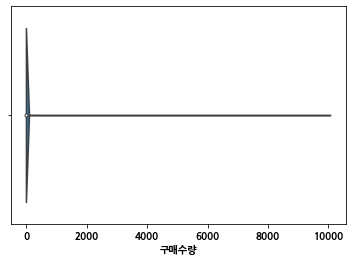

In [23]:
# 수량 분포 확인

sns.violinplot(df_shop['구매수량'])

C:\Users\jessi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='구매금액'>

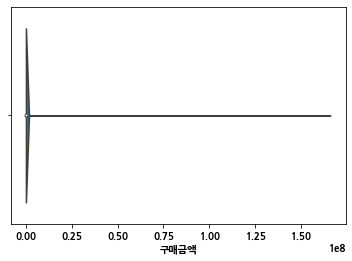

In [24]:
# 구매 금액 분포 확인

sns.violinplot(df_shop['구매금액'])

# 데이터 준비
* rfm_df를 만들기
* R(최근): 마지막 구매 이후 일수
* F(빈도): 구매 빈도
* M(금액): 거래 총액 (기여 수익)

In [35]:
# Monetary 변수 생성

df_shop['총쇼핑금액'] = df_shop['구매금액'] * df_shop['구매수량'] # 수량 * 가격

# 고객별 총 거래 수익

rfm_m = pd.DataFrame(df_shop.groupby('ID')['총쇼핑금액'].sum().reset_index())
rfm_m.columns = ['CustomerID', 'Monetary']
rfm_m.head()

,CustomerID,Monetary
0,1,3899130
1,2,32593160
2,3,186048624
3,4,119248222
4,6,371031890


In [33]:
# Frequency 변수 생성

# 고객별 구매 횟수

rfm_f = pd.DataFrame(df_shop.groupby(['ID'])['구매일자'].count().reset_index())
rfm_f.columns = ['CustomerID', 'Frequency']
rfm_f.head()

,CustomerID,Frequency
0,1,55
1,2,259
2,3,109
3,4,308
4,6,946


In [36]:
# Recency 변수 생성

# 이 데이터셋의 가장 최근 날짜
max_date = max(df_shop['구매일자'])
max_date

Timestamp('2015-12-31 00:00:00')

In [37]:
df_shop['구매텀'] = max_date - df_shop['구매일자']
df_shop.head()

,ID,성별,연령대,시도,시군구,구매일자,구매시간,구매금액,구매수량,업종,소분류명,중분류명,대분류명,총쇼핑금액,구매텀
0,1,남성,60대,서울특별시,강동구,2015-12-16,17,28000,1,백화점,수입주방,주방용품,가정,28000,15 days
1,1,남성,60대,서울특별시,강동구,2015-05-13,14,15000,1,백화점,수입주방,주방용품,가정,15000,232 days
2,1,남성,60대,서울특별시,강동구,2015-08-01,19,166400,1,백화점,N/B골프의류,골프용품,스포츠,166400,152 days
3,1,남성,60대,서울특별시,강동구,2015-12-28,12,166000,1,백화점,란제리,란제리/내의,여성의류,166000,3 days
4,1,남성,60대,서울특별시,강동구,2015-05-13,12,1000,2,백화점,어묵,젓갈/반찬,식품,2000,232 days


In [40]:
# 최신성을 얻기 위해 고객별 마지막 거래가 얼마나 지났는지 알아보기

rfm_r = pd.DataFrame(df_shop.groupby('ID')['구매텀'].min().reset_index())
rfm_r['구매텀'] = rfm_r['구매텀'].dt.days # 일수만 추출
rfm_r.columns = ['CustomerID', 'Recency']
rfm_r.head()

,CustomerID,Recency
0,1,3
1,2,11
2,3,7
3,4,3
4,6,4


In [41]:
# r, f, m을 merge

rf_merge = pd.merge(rfm_m, rfm_f, on='CustomerID', how='inner')
rfm = pd.merge(rf_merge, rfm_r, on='CustomerID', how='inner')

In [42]:
rfm.head()

,CustomerID,Monetary,Frequency,Recency
0,1,3899130,55,3
1,2,32593160,259,11
2,3,186048624,109,7
3,4,119248222,308,3
4,6,371031890,946,4


## 이상치 탐색

Text(0, 0.5, '범위')

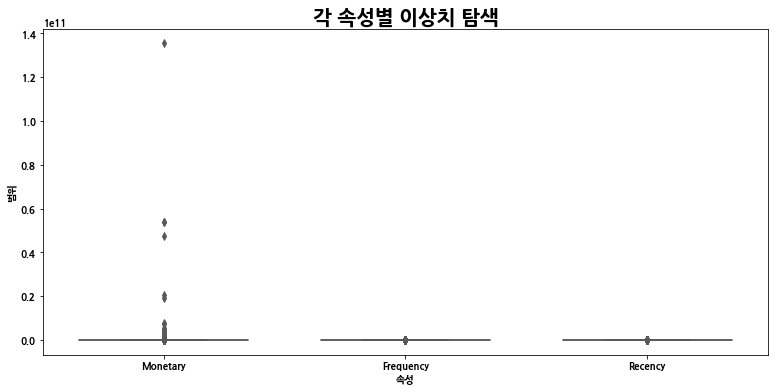

In [51]:
속성 = ['Monetary', 'Frequency', 'Recency']

plt.figure(figsize = (13, 6))
sns.boxplot(data=rfm[속성], orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
plt.title('각 속성별 이상치 탐색', fontsize=20)
plt.xlabel('속성')
plt.ylabel('범위')

Monetary에 대한 이상치가 많아보이므로 IQR로 이상치 처리

In [52]:
Q1 = rfm.Monetary.quantile(0.05)
Q3 = rfm.Monetary.quantile(0.95)
IQR = Q3 - Q1

# 해당하는 값의 범위만 rfm에 다시 할당
# 즉, 이상치를 제외

rfm = rfm[(rfm.Monetary >= Q1 - 1.5*IQR) & (rfm.Monetary <= Q3 + 1.5*IQR)] 

# 이상치 처리시 다른 속성들도 같은 갯수여야 하므로 Frequency, Recency도 똑같이 처리

Q1 = rfm.Frequency.quantile(0.05)
Q3 = rfm.Frequency.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Frequency >= Q1 - 1.5*IQR) & (rfm.Frequency <= Q3 + 1.5*IQR)]


Q1 = rfm.Recency.quantile(0.05)
Q3 = rfm.Recency.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Recency >= Q1 - 1.5*IQR) & (rfm.Recency <= Q3 + 1.5*IQR)]

In [54]:
rfm.describe()

,CustomerID,Monetary,Frequency,Recency
count,16651.000000,1.665100e+04,16651.000000,16651.000000
mean,9588.102636,3.912275e+07,194.470302,38.825176
std,5668.619789,8.217575e+07,245.882241,66.830685
min,1.000000,4.000000e+02,1.000000,0.000000
25%,4710.500000,1.026500e+06,28.000000,4.000000
50%,9411.000000,6.201204e+06,102.000000,10.000000
75%,14360.500000,3.424341e+07,264.000000,38.000000
max,20000.000000,6.259853e+08,1771.000000,367.000000


세 속성의 범위가 매우 달라보이므로 scaling이 필요

## 속성 scaling
* Standardscaler 이용

In [55]:
from sklearn.preprocessing import StandardScaler

rfm_df = rfm[['Monetary', 'Frequency', 'Recency']]

scaler = StandardScaler()

# fit_transform
scaled_rfm = scaler.fit_transform(rfm_df)
scaled_rfm.shape

(16651, 3)

In [56]:
scaled_rfm

array([[-0.42865056, -0.56724101, -0.53607488],
       [-0.07946128,  0.26244936, -0.4163658 ],
       [ 1.78800044, -0.34761709, -0.47622034],
       ...,
       [-0.4747958 , -0.70145563, -0.56600215],
       [-0.47218575, -0.75432805, -0.50614761],
       [-0.47526096, -0.78686493, -0.58096579]])

In [57]:
scaled_rfm = pd.DataFrame(scaled_rfm)
scaled_rfm.columns = ['Monetary', 'Frequency', 'Recency']
scaled_rfm.head()

,Monetary,Frequency,Recency
0,-0.428651,-0.567241,-0.536075
1,-0.079461,0.262449,-0.416366
2,1.788000,-0.347617,-0.476220
3,0.975079,0.461738,-0.536075
4,4.039137,3.056554,-0.521111


# 모델 구축
* K-Means 알고리즘 사용

C:\Users\jessi\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\jessi\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


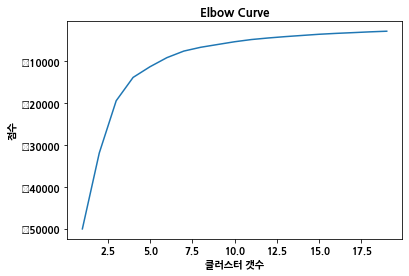

In [66]:
from sklearn.cluster import KMeans

# 클러스터 갯수 1~20까지 돌려가면서 점수 확인

k = range(1, 20)
model = [KMeans(n_clusters = i, max_iter=100) for i in k]
score = [model[i].fit(scaled_rfm).score(scaled_rfm) for i in range(len(model))]

plt.plot(k, score)
plt.xlabel('클러스터 갯수')
plt.ylabel('점수')
plt.title('Elbow Curve')
plt.show()

C:\Users\jessi\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\jessi\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


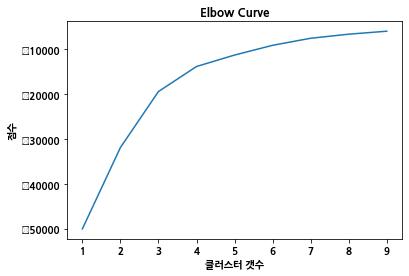

In [67]:
k = range(1, 10)
model = [KMeans(n_clusters = i, max_iter=100) for i in k]
score = [model[i].fit(scaled_rfm).score(scaled_rfm) for i in range(len(model))]

plt.plot(k, score)
plt.xlabel('클러스터 갯수')
plt.ylabel('점수')
plt.title('Elbow Curve')
plt.show()

* 엘보우 곡선으로 봤을때 k값은 4개가 적당해 보임

In [68]:
# 실루엣 분석

from sklearn.metrics import silhouette_score

range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]

for n_cluster in range_n_clusters:
    kmeans = KMeans(n_clusters=n_cluster, max_iter=100)
    kmeans.fit(scaled_rfm)
    
    cluster_labels = kmeans.labels_
    
    sil_avg = silhouette_score(scaled_rfm, cluster_labels)
    print(f"클러스터 갯수 = {n_cluster}, 실루엣 점수 = {sil_avg}")


클러스터 갯수 = 2, 실루엣 점수 = 0.5568839758681144
클러스터 갯수 = 3, 실루엣 점수 = 0.575883913647974
클러스터 갯수 = 4, 실루엣 점수 = 0.5360463565260135
클러스터 갯수 = 5, 실루엣 점수 = 0.45794695681223807
클러스터 갯수 = 6, 실루엣 점수 = 0.4669452758352198
클러스터 갯수 = 7, 실루엣 점수 = 0.4699739855061425
클러스터 갯수 = 8, 실루엣 점수 = 0.41659527813439945
클러스터 갯수 = 9, 실루엣 점수 = 0.4186980798289029
클러스터 갯수 = 10, 실루엣 점수 = 0.42209866638384047


* 클러스터 갯수 = 4 이후로 실루엣 점수가 뚝 떨어지므로 k=4로 결정

In [70]:
# k=4
model = KMeans(n_clusters=4, max_iter=100)
model.fit(scaled_rfm)

KMeans(max_iter=100, n_clusters=4)

In [73]:
model.labels_

array([0, 0, 0, ..., 0, 0, 0])

In [74]:
# 라벨값 추가

rfm['cluster'] = model.labels_
rfm.head()

,CustomerID,Monetary,Frequency,Recency,cluster
0,1,3899130,55,3,0
1,2,32593160,259,11,0
2,3,186048624,109,7,0
3,4,119248222,308,3,3
4,6,371031890,946,4,1


In [81]:
rfm

,CustomerID,Monetary,Frequency,Recency,cluster
0,1,3899130,55,3,0
1,2,32593160,259,11,0
2,3,186048624,109,7,0
3,4,119248222,308,3,3
4,6,371031890,946,4,1
...,...,...,...,...,...
16887,19995,159600,1,6,0
16888,19996,378780,27,8,0
16889,19997,107224,22,1,0
16890,19998,321700,9,5,0


## 군집별 값 분포 알아보기
* boxplot

<AxesSubplot:title={'center':'군집별 Monetary boxplot'}, xlabel='cluster', ylabel='Monetary'>

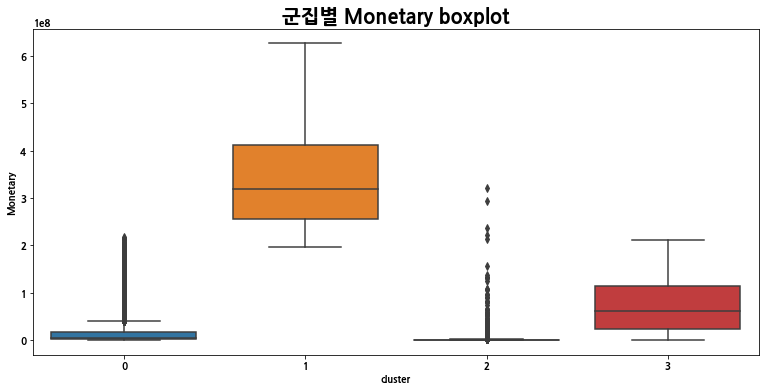

In [77]:
plt.figure(figsize=(13, 6))
plt.title('군집별 Monetary boxplot', fontsize=20)
sns.boxplot(data=rfm, x='cluster', y='Monetary')

<AxesSubplot:title={'center':'군집별 Frequency boxplot'}, xlabel='cluster', ylabel='Frequency'>

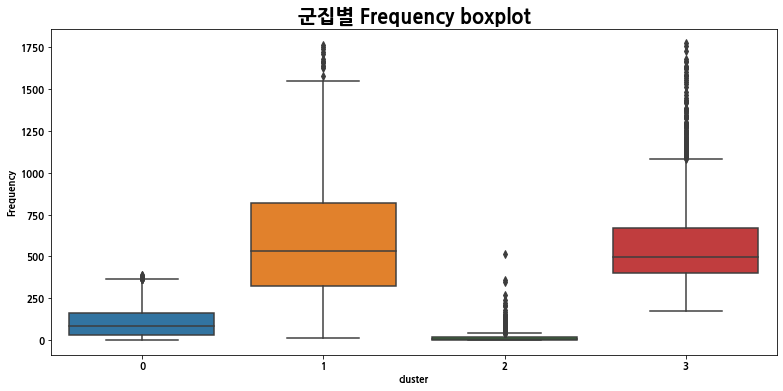

In [78]:
plt.figure(figsize=(13, 6))
plt.title('군집별 Frequency boxplot', fontsize=20)
sns.boxplot(data=rfm, x='cluster', y='Frequency')

<AxesSubplot:title={'center':'군집별 Recency boxplot'}, xlabel='cluster', ylabel='Recency'>

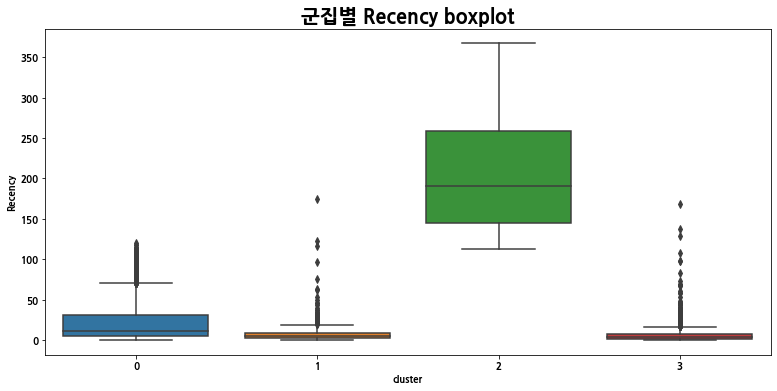

In [79]:
plt.figure(figsize=(13, 6))
plt.title('군집별 Recency boxplot', fontsize=20)
sns.boxplot(data=rfm, x='cluster', y='Recency')

# 최종 분석 결과 정리

* 큰 수익을 창출하고 빈번하게 구매하는 집단은 클러스터 1 집단 (플래티넘)
* 상대적으로 큰 수익은 아니지만 빈번한 구매가 이루어지는 집단은 클러스터 3 집단 (골드)
* 구매빈도도 적고 수익도 적은 집단은 클러스터 0집단 (실버)
* 클러스터 2집단의 경우에는 최신성도 가장 적으면서 빈번 구매도 X, 수익도 가장 적으므로 비즈니스 관점에서 중요도가 가장 낮아보임. 분석시 제외해도 될 듯.

# 티어별 고객 정보 CSV 저장
* 플래티넘 그룹 - 클러스터 1
* 골드 그룹 - 클러스터 3
* 실버 그룹 - 클러스터 0

In [84]:
df = pd.merge(df_shop, rfm, left_on='ID', right_on='CustomerID', how='left')
df.drop(columns=['CustomerID'], inplace=True)
df.head()

,ID,성별,연령대,시도,시군구,구매일자,구매시간,구매금액,구매수량,업종,소분류명,중분류명,대분류명,총쇼핑금액,구매텀,Monetary,Frequency,Recency,cluster
0,1,남성,60대,서울특별시,강동구,2015-12-16,17,28000,1,백화점,수입주방,주방용품,가정,28000,15 days,3899130.0,55.0,3.0,0.0
1,1,남성,60대,서울특별시,강동구,2015-05-13,14,15000,1,백화점,수입주방,주방용품,가정,15000,232 days,3899130.0,55.0,3.0,0.0
2,1,남성,60대,서울특별시,강동구,2015-08-01,19,166400,1,백화점,N/B골프의류,골프용품,스포츠,166400,152 days,3899130.0,55.0,3.0,0.0
3,1,남성,60대,서울특별시,강동구,2015-12-28,12,166000,1,백화점,란제리,란제리/내의,여성의류,166000,3 days,3899130.0,55.0,3.0,0.0
4,1,남성,60대,서울특별시,강동구,2015-05-13,12,1000,2,백화점,어묵,젓갈/반찬,식품,2000,232 days,3899130.0,55.0,3.0,0.0


In [86]:
# 플래티넘 그룹
platinum_df = df[df['cluster'] == 1]
platinum_df.shape

(480630, 19)

In [87]:
# 골드 그룹
gold_df = df[df['cluster'] == 3]
gold_df.shape

(1504988, 19)

In [88]:
# 실버 그룹
silver_df = df[df['cluster'] == 0]
silver_df.shape

(1221269, 19)

In [89]:
# csv 파일로 저장
platinum_df.to_csv('data/platinum_df.csv', index=False)
gold_df.to_csv('data/gold_df.csv', index=False)
silver_df.to_csv('data/silver_df.csv', index=False)

In [90]:
# 확인
p = pd.read_csv('data/platinum_df.csv')
p.head()

,ID,성별,연령대,시도,시군구,구매일자,구매시간,구매금액,구매수량,업종,소분류명,중분류명,대분류명,총쇼핑금액,구매텀,Monetary,Frequency,Recency,cluster
0,6,여성,60대,서울특별시,송파구,2015-07-27,19,6980,1,대형마트,냉장면류,냉장식사HMR,가공HMR,6980,157 days,371031890.0,946.0,4.0,1.0
1,6,여성,60대,서울특별시,송파구,2015-07-27,19,1980,1,대형마트,건나물,나물,두부/콩나물/나물,1980,157 days,371031890.0,946.0,4.0,1.0
2,6,여성,60대,서울특별시,송파구,2015-07-27,19,4600,1,대형마트,차별화계란,계란,계란,4600,157 days,371031890.0,946.0,4.0,1.0
3,6,여성,60대,서울특별시,송파구,2015-07-27,19,2000,1,대형마트,삶은나물,나물,두부/콩나물/나물,2000,157 days,371031890.0,946.0,4.0,1.0
4,6,여성,60대,서울특별시,송파구,2015-07-27,19,1900,1,대형마트,건나물,나물,두부/콩나물/나물,1900,157 days,371031890.0,946.0,4.0,1.0


In [91]:
g = pd.read_csv('data/gold_df.csv')
g.head()

,ID,성별,연령대,시도,시군구,구매일자,구매시간,구매금액,구매수량,업종,소분류명,중분류명,대분류명,총쇼핑금액,구매텀,Monetary,Frequency,Recency,cluster
0,4,남성,60대,경기도,남양주시,2015-10-08,19,339000,1,백화점,직수입 골프의류,골프용품,스포츠,339000,84 days,119248222.0,308.0,3.0,3.0
1,4,남성,60대,경기도,남양주시,2015-01-20,14,900,1,대형마트,양배추,잎채소,잎/샐러드채소,900,345 days,119248222.0,308.0,3.0,3.0
2,4,남성,60대,경기도,남양주시,2015-01-20,14,5900,1,대형마트,일반닭,닭고기,닭고기,5900,345 days,119248222.0,308.0,3.0,3.0
3,4,남성,60대,경기도,남양주시,2015-01-20,14,5000,1,대형마트,다이소,균일가,주방잡화,5000,345 days,119248222.0,308.0,3.0,3.0
4,4,남성,60대,경기도,남양주시,2015-08-28,13,15000,15,대형마트,브랜드,골프,스포츠브랜드,225000,125 days,119248222.0,308.0,3.0,3.0


In [92]:
s = pd.read_csv('data/silver_df.csv')
s.head()

,ID,성별,연령대,시도,시군구,구매일자,구매시간,구매금액,구매수량,업종,소분류명,중분류명,대분류명,총쇼핑금액,구매텀,Monetary,Frequency,Recency,cluster
0,1,남성,60대,서울특별시,강동구,2015-12-16,17,28000,1,백화점,수입주방,주방용품,가정,28000,15 days,3899130.0,55.0,3.0,0.0
1,1,남성,60대,서울특별시,강동구,2015-05-13,14,15000,1,백화점,수입주방,주방용품,가정,15000,232 days,3899130.0,55.0,3.0,0.0
2,1,남성,60대,서울특별시,강동구,2015-08-01,19,166400,1,백화점,N/B골프의류,골프용품,스포츠,166400,152 days,3899130.0,55.0,3.0,0.0
3,1,남성,60대,서울특별시,강동구,2015-12-28,12,166000,1,백화점,란제리,란제리/내의,여성의류,166000,3 days,3899130.0,55.0,3.0,0.0
4,1,남성,60대,서울특별시,강동구,2015-05-13,12,1000,2,백화점,어묵,젓갈/반찬,식품,2000,232 days,3899130.0,55.0,3.0,0.0
